In [3]:
import numpy as np
import numpy as np 
import pandas as pd
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import rdMolDescriptors
from rdkit import DataStructs
from ast import literal_eval
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import svm
from sklearn import metrics
from sklearn.svm import SVC
import pickle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [4]:
new_df = pd.read_csv('../Data/167_features.csv')
new_df = new_df.loc[:, ~new_df.columns.str.contains('^Unnamed')]

In [5]:
x_list = list(new_df)
x_list = x_list[:-1]
# x_list

In [6]:
X = np.asarray(new_df[x_list])
Y = np.asarray(new_df['general_syntax#'])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle= True)

In [7]:
lineReg = LinearRegression()
lineReg.fit(X_train, y_train)
print('Score: ', lineReg.score(X_test, y_test))
# print('Weights: ', lineReg.coef_)

Score:  0.22846384030922584


In [8]:
svm_initial_model = pickle.load(open('../models/svm_initial_model.sav', 'rb'))
y_pred = svm_initial_model.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5201169020944959


In [9]:
svc_model2 = pickle.load(open('../models/poly_svc_model2.sav', 'rb'))

In [10]:
y_pred = svc_model2.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8192888455918168


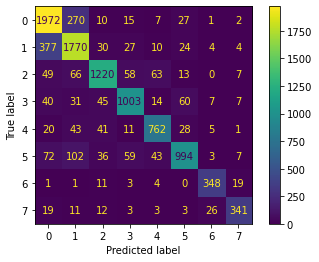

In [11]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=svc_model2.classes_)
disp.plot()

In [12]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.86      0.81      2304
           1       0.77      0.79      0.78      2246
           2       0.87      0.83      0.85      1476
           3       0.85      0.83      0.84      1207
           4       0.84      0.84      0.84       911
           5       0.87      0.76      0.81      1316
           6       0.88      0.90      0.89       387
           7       0.88      0.82      0.85       418

    accuracy                           0.82     10265
   macro avg       0.84      0.83      0.83     10265
weighted avg       0.82      0.82      0.82     10265

